# ライブラリの読み込み

### 基本ライブラリ

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

### 機械学習ライブラリ

In [2]:
import lightgbm as lgb

### Open Bandit Pipeline(課題データを利用した分析、機械学習、polcy評価のためのライブラリ)

In [3]:
#データの前処理
from obp.dataset import OpenBanditDataset, BanditFeedback
#シミュレーション
from obp.simulator import run_bandit_simulation
#policy
from obp.policy import BernoulliTS,LinTS
#off policy evaluation
from obp.ope import (
    OffPolicyEvaluation,
    DoublyRobust,
    ReplayMethod,
)

### 可視化、出力ライブラリ

In [110]:
import openpyxl
import matplotlib.pyplot as plt
import graphviz

### Open Bandit Pipelineの一部クラスの改変（オーバーライド）に使うライブラリ

In [5]:
from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass
from typing import Optional, Tuple
from sklearn.base import BaseEstimator, clone, is_classifier
from sklearn.model_selection import KFold
from obp.utils import check_bandit_feedback_inputs

# データの読み込みと確認

In [6]:
pd.read_csv('random/all/all.csv').head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:00.007365+00:00,21,1,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-11-24 00:00:00.015668+00:00,43,2,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-11-24 00:00:00.016438+00:00,62,3,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-11-24 00:00:01.856987+00:00,8,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-11-24 00:00:01.857185+00:00,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
pd.read_csv('random/all/item_context.csv').head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,d1e00cff339048c08ea666193d5033a3,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
1,1,-0.543775,d74a92caf4244a36013cd3c0d63dd295,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
2,2,0.972752,d74a92caf4244a36013cd3c0d63dd295,54426f203dec4609025bdcd3f70e1043,ff8b1f6688f83613aecd3fbc881bafb0
3,3,-0.521473,e3f540fa6d7911cd4ec38f8c3da11e67,1f692a394cf4cff118a1de54b5531e89,ad64ce82bf623357a97a1164f463a5da
4,4,1.909430,9b6d0728ea28dd8aa485eb824ce58f05,f4ae697a3823f829e791beef466f848b,ff8b1f6688f83613aecd3fbc881bafb0


- all.csv, item_context.csv共に、featureはitem_feature_0を除いて文字列データであることが確認できる
- clickを目的変数としたいが、その予測は最終目標ではない(最終目標はクリック率の予測)
- positionが3つ用意されているので、今回のレコメンドモデルはこれに準拠し、一度に3つのアイテムを推薦する
- 時系列は説明変数に含めないが、学習データとテストデータの選択には時系列をシャッフルするようにする
- user-item_affinity_0~80はsparseなデータで重要度が低く、使用しない
- その他は説明変数とする


# データの前処理

In [8]:
#データpathの指定
data_path = Path('.').resolve().parents[1] / 'Desktop/機械学習'

In [9]:
dataset = OpenBanditDataset(behavior_policy = 'random', campaign = 'all', data_path = data_path)

- データの読み込み(配布されたデータを読み込んでいる)と前処理
    - 使用しないデータを削除、データを時系列順に並べ替え
    - user_featureはダミー変数化、item_featureは0を除いてラベルエンコーディング
    - 2ファイルを結合

In [10]:
bandit_feedback = dataset.obtain_batch_bandit_feedback(is_timeseries_split = False)

- データをバンディットアルゴリズムの用語に変換していく(例:clickをrewardに変換する。　クリックされたとき報酬1を得、されない時0を得ると解釈する)
- 訓練データとテストデータに分割する　
    - 時系列順に並べず、シャッフルする

In [11]:
#bandit_feedbackの内容確認
print(bandit_feedback.keys())
print(bandit_feedback)

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'reward_test', 'pscore', 'context', 'action_context'])
{'n_rounds': 1048575, 'n_actions': 80, 'action': array([21, 43, 62, ..., 42, 68, 77], dtype=int64), 'position': array([0, 1, 2, ..., 2, 0, 1]), 'reward': array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 'reward_test': array([0, 0, 0, ..., 0, 0, 0], dtype=int64), 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]), 'context': array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]], dtype=uint8), 'action_context': array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
        -4.99171626e-01],
       [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
        -5.43775368e-01],
       [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
         9.72751855e-01],
       [ 1.10000000e+01,  1.00000000e+00,  

各データの意味
- **n_rounds**:試行数のこと
- **n_actions**:とりうる行動の種類、試行数と合わせて80種類のアイテムから1つずつ推薦する、すると報酬0か報酬１が出力されるという試行を1048575試行行ったということがわかる
- **action**:選択された行動(=アイテム)
- **position**:推薦された位置 012 が左真ん中右に対応
- **reward**:報酬。クリックされると1、されないと0、累積報酬を高めるのがレコメンドモデルの目標
- **reward_test**:テストデータの報酬、時系列をシャッフルしているとrewardと同一、OffPolicyEvaluationの評価に使うが今回は無関係
- **pscore**:行動選択確率でpropensity_scoreと同一。今回はrandomにアイテムがレコメンドされるので全て1/80=0.0125となっている
- **context**:ユーザーの文脈データ(特徴量)
- **action_context**:行動(アイテム)の文脈データ(特徴量)

# 仮想policyの設定とシミュレーション

### 仮想policyの設定

In [12]:
counterfactual_policy = LinTS(
                      dim = dataset.dim_context,     #contextベクトルの次元,dim = bandit_feedback['context'].shape[1]のこと
                      n_actions = dataset.n_actions, #行動の数
                      len_list = dataset.len_list,   #ポジションの数
                      random_state = 3105,           #random seed
)

dim = bandit_feedback['context'].shape[1]

In [13]:
action_dist = run_bandit_simulation(bandit_feedback = bandit_feedback, policy =counterfactual_policy)

100%|██████████████████████████████████████████████████████████████████████| 1048575/1048575 [4:44:30<00:00, 61.42it/s]


仮想policyを配布されたログ上でシミュレーションし、行動を選択する
その後、行動選択確率(例えばitem_id1を1で、他のアイテムの選択確率は0というようなリストを試行ごとに作成する)をaction_distとして返す
- 選ばれたアイテムの確率を1、それ以外を0とする変換をしているだけなので、0と1しか出てこないはず

### シミュレーションが正常に機能しているかの確認

In [14]:
action_dist

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

action_distは0と1でしか構成されていないように見えるが、念のため確認

In [15]:
u, counts = np.unique(action_dist, return_counts=True)                #action_distに含まれる値の種類とそれぞれの数を取得
print(u)                                                              #action_distに含まれる値の種類
print(counts)                                                         #[0の数,1の数]
print(counts[1] == bandit_feedback['n_rounds'] * dataset.len_list)    #行動の総数が試行数*positionの数と等しいか否か

[0. 1.]
[248512275   3145725]
True


action_distには選択確率0と1しか含まれていないことが分かった、また1の数(=行動の総数)も試行数*3(positionの数)となっておりシミュレーションは正常に機能していることが分かる

# rewardを予測する機械学習

### rewardを予測する機械学習モデルのクラスを編集する

In [137]:
@dataclass
class RegressionModel(BaseEstimator):
    """Machine learning model to estimate the mean reward function (:math:`q(x,a):= \\mathbb{E}[r|x,a]`).

    Note
    -------
    Reward (or outcome) :math:`r` must be either binary or continuous.

    Parameters
    ------------
    base_model: BaseEstimator
        A machine learning model used to estimate the mean reward function.

    n_actions: int
        Number of actions.

    len_list: int, default=1
        Length of a list of actions recommended in each impression.
        When Open Bandit Dataset is used, 3 should be set.

    action_context: array-like, shape (n_actions, dim_action_context), default=None
        Context vector characterizing each action, vector representation of each action.
        If not given, then one-hot encoding of the action variable is automatically used.

    fitting_method: str, default='normal'
        Method to fit the regression model.
        Must be one of ['normal', 'iw', 'mrdr'] where 'iw' stands for importance weighting and
        'mrdr' stands for more robust doubly robust.

    References
    -----------
    Mehrdad Farajtabar, Yinlam Chow, and Mohammad Ghavamzadeh.
    "More Robust Doubly Robust Off-policy Evaluation.", 2018.

    Yi Su, Maria Dimakopoulou, Akshay Krishnamurthy, and Miroslav Dudik.
    "Doubly Robust Off-Policy Evaluation with Shrinkage.", 2020.

    Yusuke Narita, Shota Yasui, and Kohei Yata.
    "Off-policy Bandit and Reinforcement Learning.", 2020.

    """

    base_model: BaseEstimator
    n_actions: int
    len_list: int = 1
    action_context: Optional[np.ndarray] = None
    fitting_method: str = "normal"

    def __post_init__(self) -> None:
        """Initialize Class."""
        self.base_model_list = [
            clone(self.base_model) for _ in np.arange(self.len_list)
        ]
        
    def fit(
        self,
        context: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        pscore: Optional[np.ndarray] = None,
        position: Optional[np.ndarray] = None,
        action_dist: Optional[np.ndarray] = None,
    ) -> None:
        """Fit the regression model on given logged bandit feedback data.

        Parameters
        ----------
        context: array-like, shape (n_rounds, dim_context)
            Context vectors in each round, i.e., :math:`x_t`.

        action: array-like, shape (n_rounds,)
            Action sampled by a behavior policy in each round of the logged bandit feedback, i.e., :math:`a_t`.

        reward: array-like, shape (n_rounds,)
            Observed rewards (or outcome) in each round, i.e., :math:`r_t`.

        pscore: array-like, shape (n_rounds,), default=None
            Action choice probabilities (propensity score) of a behavior policy
            in the training logged bandit feedback.
            When None is given, the the behavior policy is assumed to be a uniform one.

        position: array-like, shape (n_rounds,), default=None
            Positions of each round in the given logged bandit feedback.
            If None is set, a regression model assumes that there is only one position.
            When `len_list` > 1, this position argument has to be set.

        action_dist: array-like, shape (n_rounds, n_actions, len_list), default=None
            Action choice probabilities by the evaluation policy (can be deterministic), i.e., :math:`\\pi_e(a_t|x_t)`.
            When either of 'iw' or 'mrdr' is used as the 'fitting_method' argument, then `action_dist` must be given.

        """
        n_rounds = context.shape[0]

        for position_ in np.arange(self.len_list):
            idx = position == position_
            X = self._pre_process_for_reg_model(
                context=context[idx],
                action=action[idx],
                action_context=self.action_context,
            )
###与えられたmodelによってrewardを予測する訓練をする（LightGBM専用）###
            if self.fitting_method == "normal":
                clf = self.base_model_list[position_]
                clf.fit(X, reward[idx],
                        eval_set= [(X, reward[idx])], #評価対象
                        eval_metric='auc',            #評価にaucを設定
                        early_stopping_rounds=30,     #アーリーストッピング
                        verbose = -1,                 #学習過程非表示
                       )
####決定木を描画する###
###特徴量に名前を付けるとかえってややこしくなるので名前は付けない###
                ax_tree = lgb.plot_tree(clf, tree_index=0, figsize=(20, 20), show_info=['split_gain'])
                plt.show()
                graph = lgb.create_tree_digraph(clf, tree_index=0, format='png', name='Tree')
###決定木の保存,n_fold>1の時は上書きされてしまうので注意###
                if position_ == 0:
                    graph.render('position_1_tree',view=True)
                if position_ == 1:
                    graph.render('position_2_tree',view=True)
                if position_ == 2:
                    graph.render('position_3_tree',view=True)
###評価を表示する(aucのスコア)###
                ax_metric = lgb.plot_metric(clf, metric='auc', figsize=(20, 20))
                plt.show()
                
    def predict(self, context: np.ndarray) -> np.ndarray:
        """Predict the mean reward function.

        Parameters
        -----------
        context: array-like, shape (n_rounds_of_new_data, dim_context)
            Context vectors for new data.

        Returns
        -----------
        estimated_rewards_by_reg_model: array-like, shape (n_rounds_of_new_data, n_actions, len_list)
            Estimated expected rewards for new data by the regression model.

        """
        n_rounds_of_new_data = context.shape[0]
        ones_n_rounds_arr = np.ones(n_rounds_of_new_data, int)
        estimated_rewards_by_reg_model = np.zeros(
            (n_rounds_of_new_data, self.n_actions, self.len_list)
        )
###与えられたreward=1となる確率を予測し、それを期待報酬とする###
        for action_ in np.arange(self.n_actions):
            for position_ in np.arange(self.len_list):
                X = self._pre_process_for_reg_model(
                    context=context,
                    action=action_ * ones_n_rounds_arr,
                    action_context=self.action_context,
                )
                estimated_rewards_ = (
                    self.base_model_list[position_].predict_proba(X)[:, 1]
                    if is_classifier(self.base_model_list[position_])
                    else self.base_model_list[position_].predict(X)
                )
                estimated_rewards_by_reg_model[
                    np.arange(n_rounds_of_new_data),
                    action_ * ones_n_rounds_arr,
                    position_ * ones_n_rounds_arr,
                ] = estimated_rewards_
        return estimated_rewards_by_reg_model


    def fit_predict(
        self,
        context: np.ndarray,
        action: np.ndarray,
        reward: np.ndarray,
        pscore: Optional[np.ndarray] = None,
        position: Optional[np.ndarray] = None,
        action_dist: Optional[np.ndarray] = None,
        n_folds: int = 1,
        random_state: Optional[int] = None,
    ) -> None:
        """Fit the regression model on given logged bandit feedback data and predict the reward function of the same data.

        Note
        ------
        When `n_folds` is larger than 1, then the cross-fitting procedure is applied.
        See the reference for the details about the cross-fitting technique.

        Parameters
        ----------
        context: array-like, shape (n_rounds, dim_context)
            Context vectors in each round, i.e., :math:`x_t`.

        action: array-like, shape (n_rounds,)
            Action sampled by a behavior policy in each round of the logged bandit feedback, i.e., :math:`a_t`.

        reward: array-like, shape (n_rounds,)
            Observed rewards (or outcome) in each round, i.e., :math:`r_t`.

        pscore: array-like, shape (n_rounds,), default=None
            Action choice probabilities (propensity score) of a behavior policy
            in the training logged bandit feedback.
            When None is given, the the behavior policy is assumed to be a uniform one.

        position: array-like, shape (n_rounds,), default=None
            Positions of each round in the given logged bandit feedback.
            If None is set, a regression model assumes that there is only one position.
            When `len_list` > 1, this position argument has to be set.

        action_dist: array-like, shape (n_rounds, n_actions, len_list), default=None
            Action choice probabilities by the evaluation policy (can be deterministic), i.e., :math:`\\pi_e(a_t|x_t)`.
            When either of 'iw' or 'mrdr' is used as the 'fitting_method' argument, then `action_dist` must be given.

        n_folds: int, default=1
            Number of folds in the cross-fitting procedure.
            When 1 is given, the regression model is trained on the whole logged bandit feedback data.

        random_state: int, default=None
            `random_state` affects the ordering of the indices, which controls the randomness of each fold.
            See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html for the details.

        Returns
        -----------
        estimated_rewards_by_reg_model: array-like, shape (n_rounds, n_actions, len_list)
            Estimated expected rewards for new data by the regression model.

        """

        n_rounds = context.shape[0]

        
####fitとpredictを行う###
        if n_folds == 1:
            self.fit(
                context=context,
                action=action,
                reward=reward,
                pscore=pscore,
                position=position,
                action_dist=action_dist,
            )
            return self.predict(context=context)
        else:
            estimated_rewards_by_reg_model = np.zeros(
                (n_rounds, self.n_actions, self.len_list)
            )
###データをn分割してfit_predict###
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
        kf.get_n_splits(context)
        for train_idx, test_idx in kf.split(context):
            action_dist_tr = (
                action_dist[train_idx] if action_dist is not None else action_dist
            )
            self.fit(
                context=context[train_idx],
                action=action[train_idx],
                reward=reward[train_idx],
                pscore=pscore[train_idx],
                position=position[train_idx],
                action_dist=action_dist_tr,
            )
            estimated_rewards_by_reg_model[test_idx, :, :] = self.predict(
                context=context[test_idx]
            )
        return estimated_rewards_by_reg_model

###～のuser_featureを持つ人に～なitem_featureを持つitem_id～をレコメンドしたという配列を作成###
    def _pre_process_for_reg_model(
        self,
        context: np.ndarray,
        action: np.ndarray,
        action_context: np.ndarray,
    ) -> np.ndarray:
        """Preprocess feature vectors to train a give regression model.

        Note
        -----
        Please override this method if you want to use another feature enginnering
        for training the regression model.

        Parameters
        -----------
        context: array-like, shape (n_rounds,)
            Context vectors in the training logged bandit feedback.

        action: array-like, shape (n_rounds,)
            Action sampled by a behavior policy in each round of the logged bandit feedback, i.e., :math:`a_t`.

        action_context: array-like, shape shape (n_actions, dim_action_context)
            Context vector characterizing each action, vector representation of each action.

        """
        return np.c_[context, action_context[action]]

〇obp.opeのRegressionmodelのソースコードを編集し、lightgbmの決定木を出力するようにする
<br>
<br>
〇簡便化のため、エラーメッセージや変数チェック、使用しない部分を削除している
<br>
<br>
〇'''　'''で挟まれたコメントソースコードに記載されているもの、###にあるものは私の追加したコメント
<br>
<br>
〇lgbのplot_treeメソッドをハードで使用しているので、base_modelでLGBMClassifier意外を使用する場合は適宜変更する必要あり
  - 例えばRandomForestを使用する場合.estimators_で推定器を一つ指定し、export_graphviz、.writeメソッドで出力する等  
<br>

〇fitメソッドに描画、保存のコードを追加している
  - positionごとに予測を行うので3つの決定器が出力されるk-fold法を使う場合、それがk回繰り返されるので3*k 個出力される

## 機械学習モデルの指定と学習

In [154]:
lgbm = lgb.LGBMClassifier(
    metric = 'auc',      #評価はaucで行う
    random_state = 3105, #random_seed
)

学習モデルにはLightGBMを使用する
- base_modelはsklearn.BaseEstimatorにしか対応していないので、sklearnAPIのLGBMClassifierを利用

In [139]:
#RegressionModelに必要な変数を渡す

regression_model = RegressionModel(
    n_actions=dataset.n_actions,           #80種類のアイテムから1つ選択
    len_list=dataset.len_list,             #3つのポジションに対してレコメンド
    action_context=dataset.action_context, #アイテム特徴量
    base_model=lgbm,                       #LightGBMを使用
)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.869193


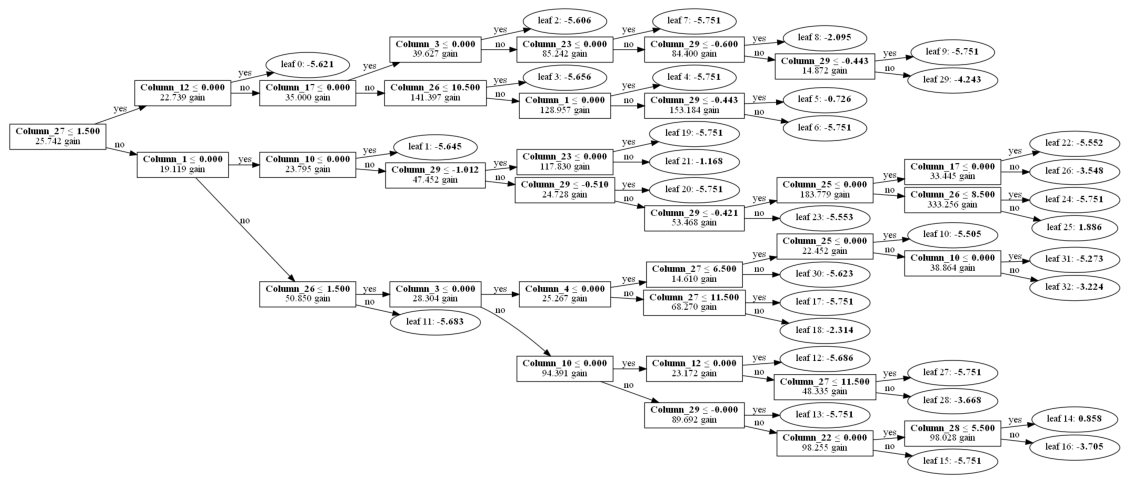

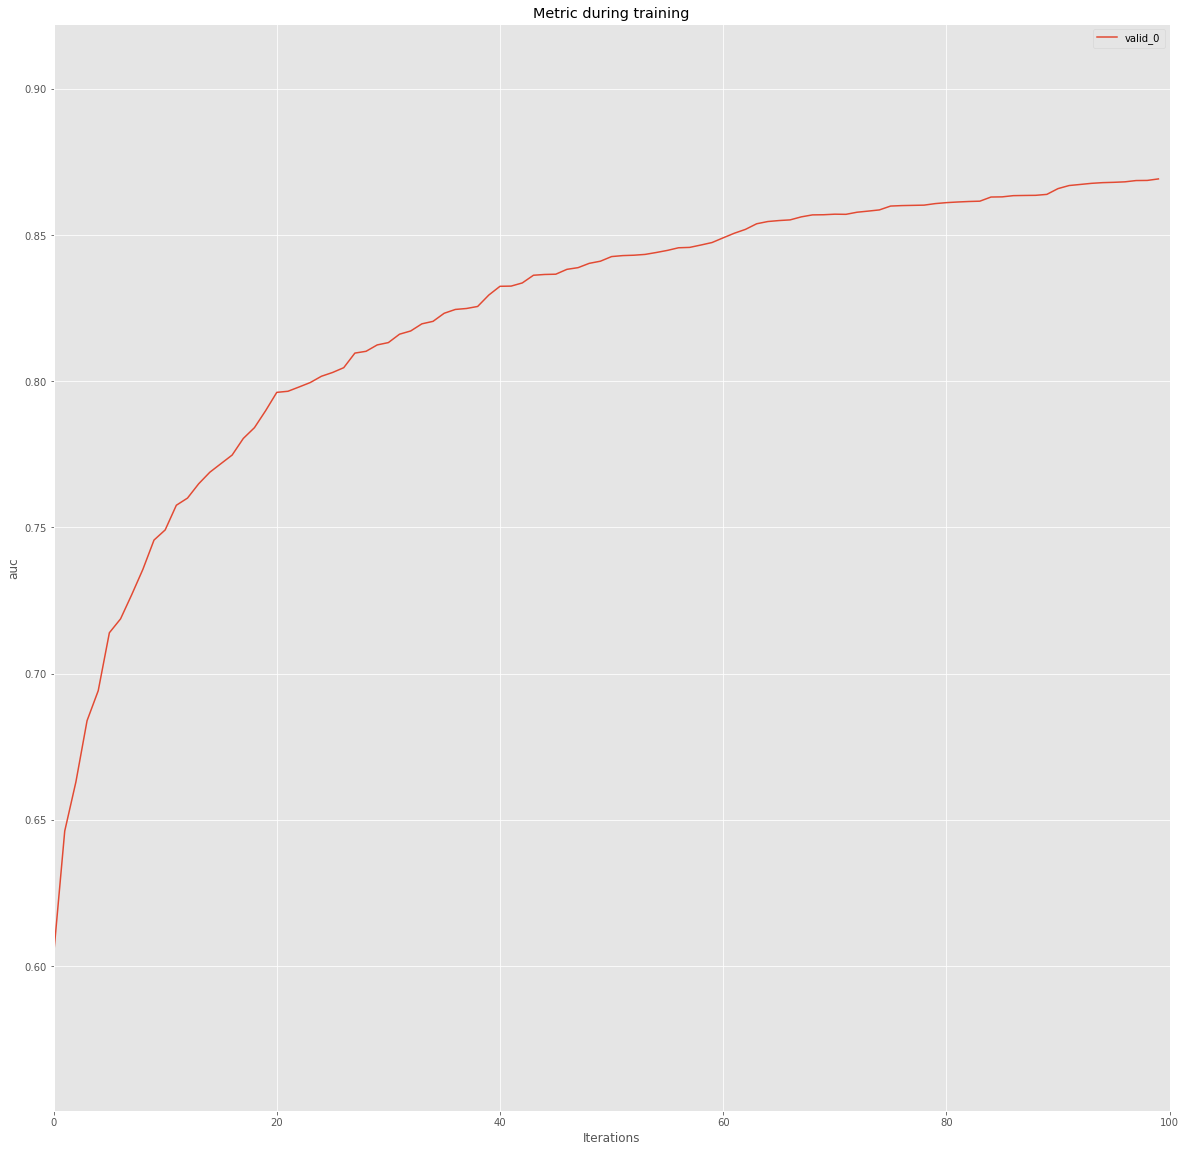

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.867634


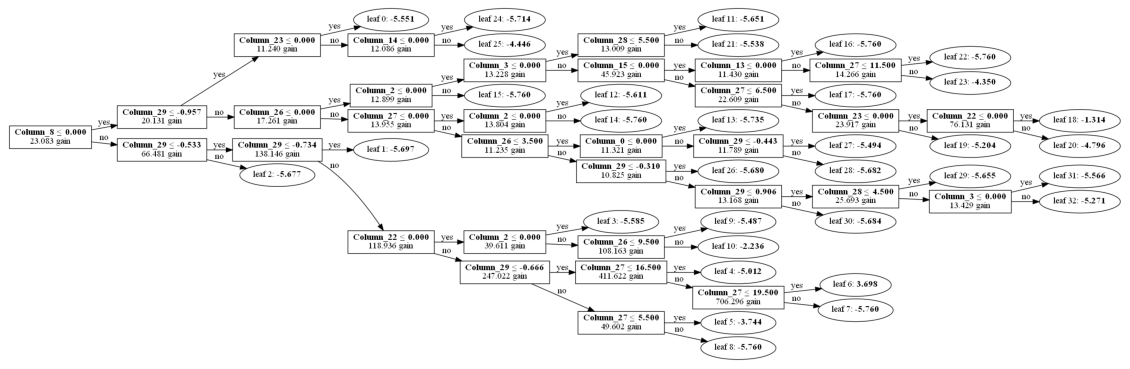

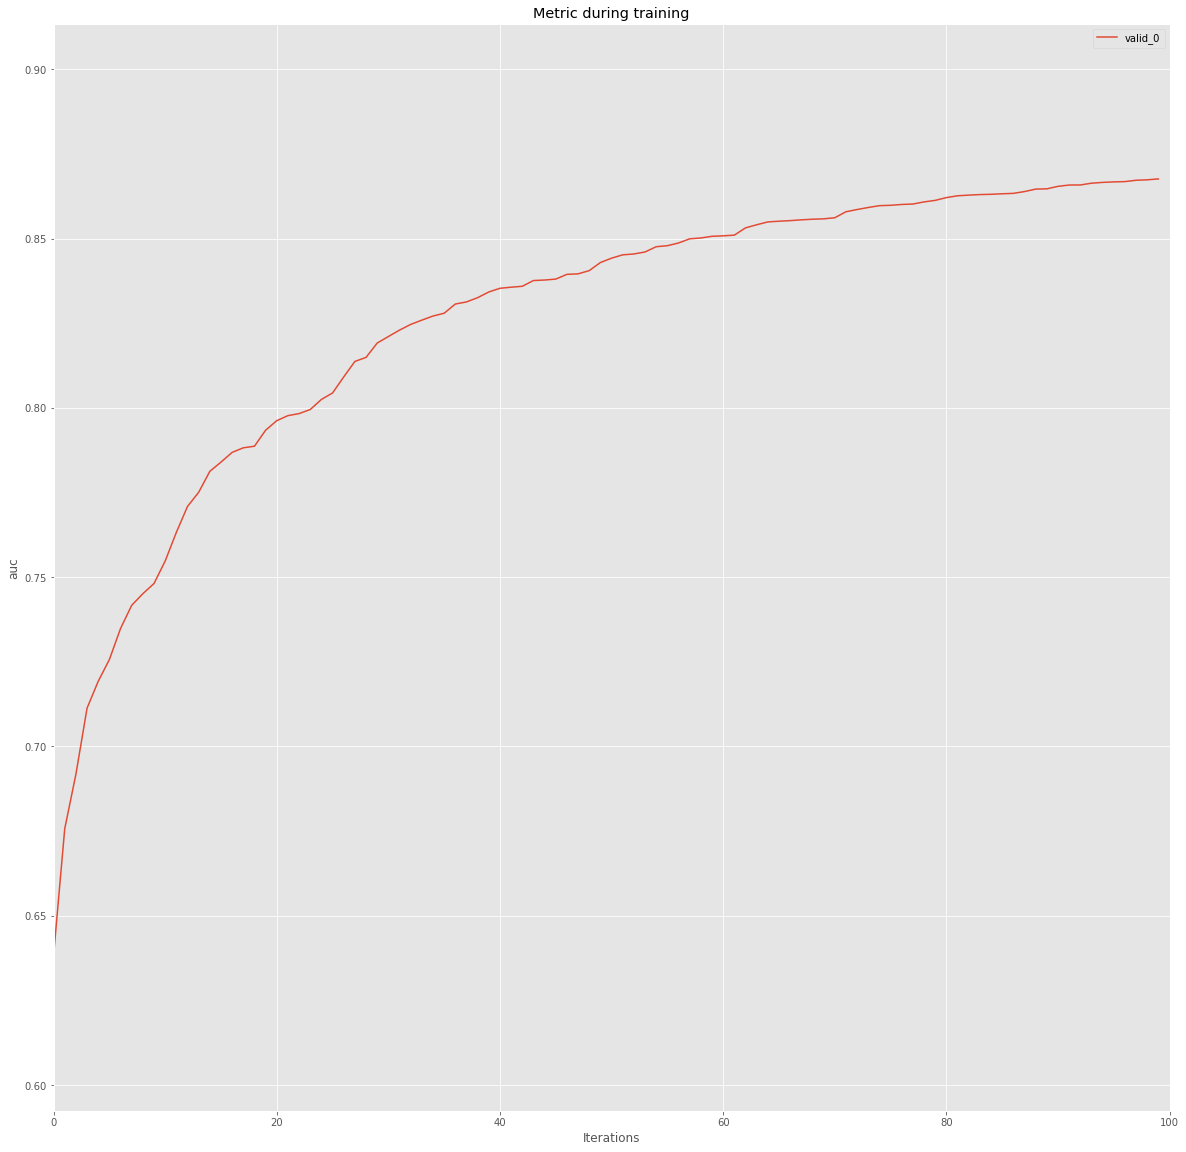

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.872833


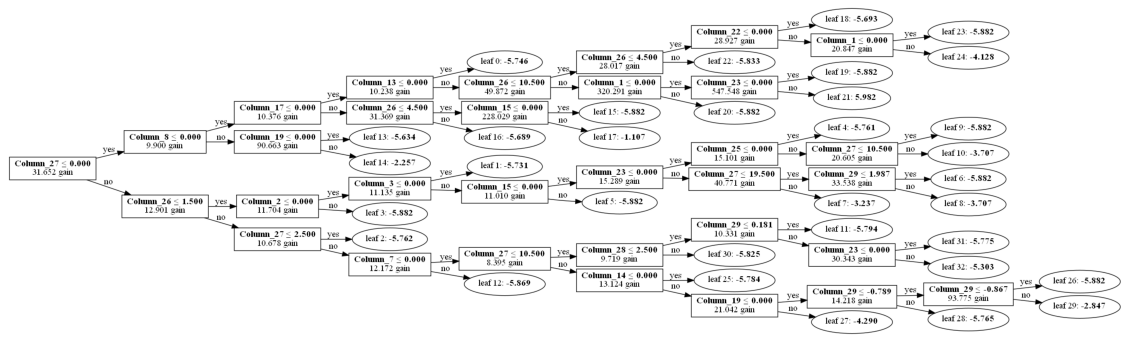

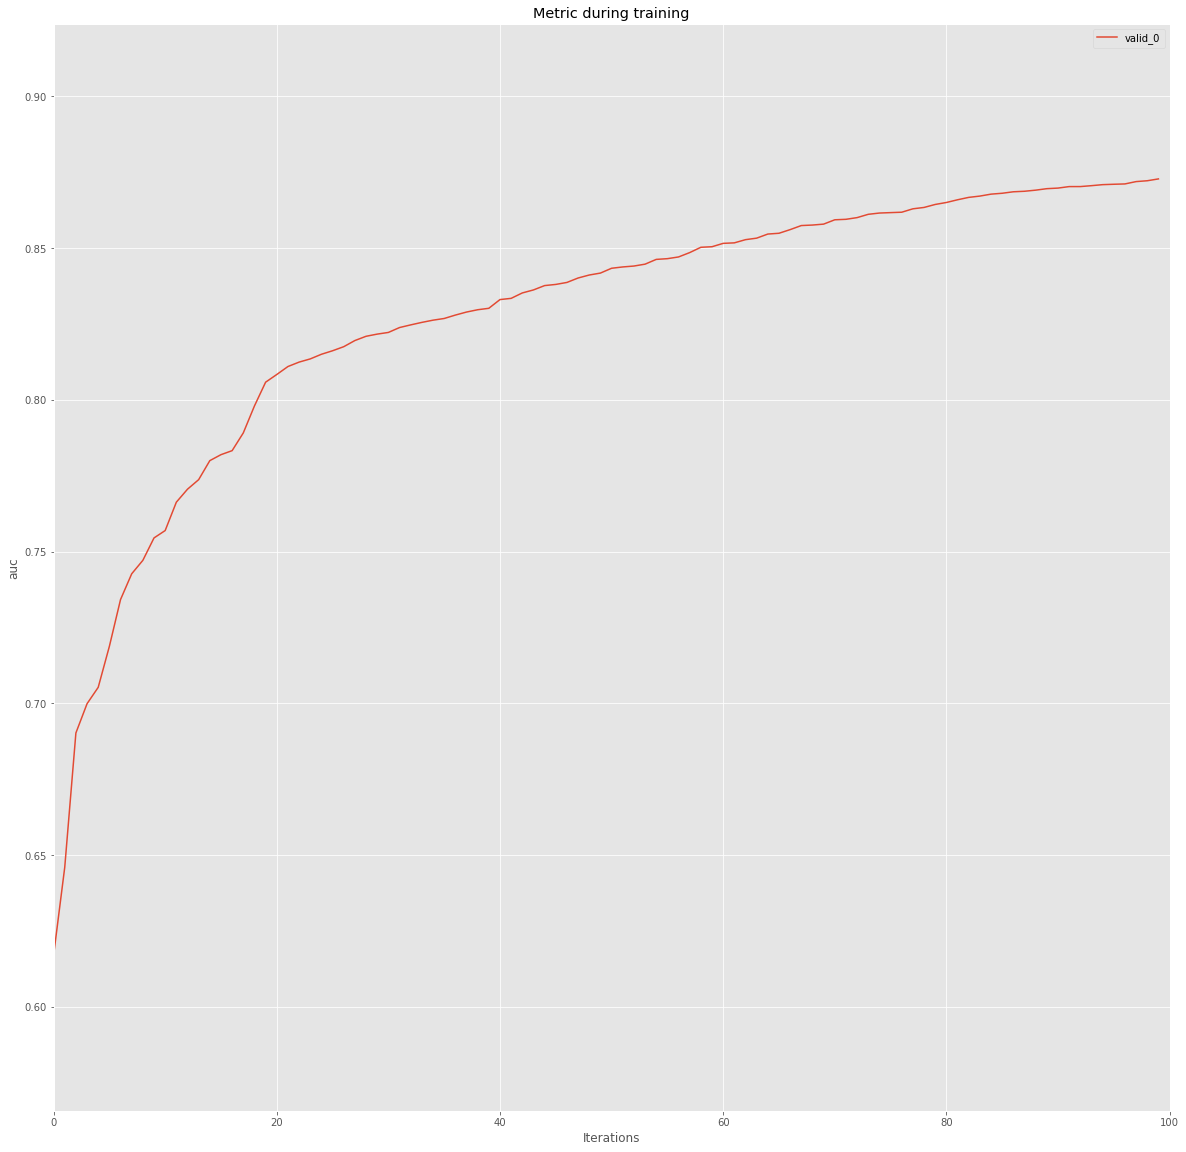

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.865221


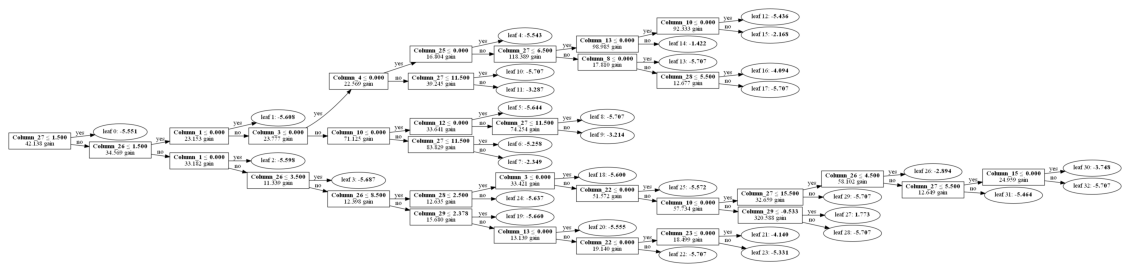

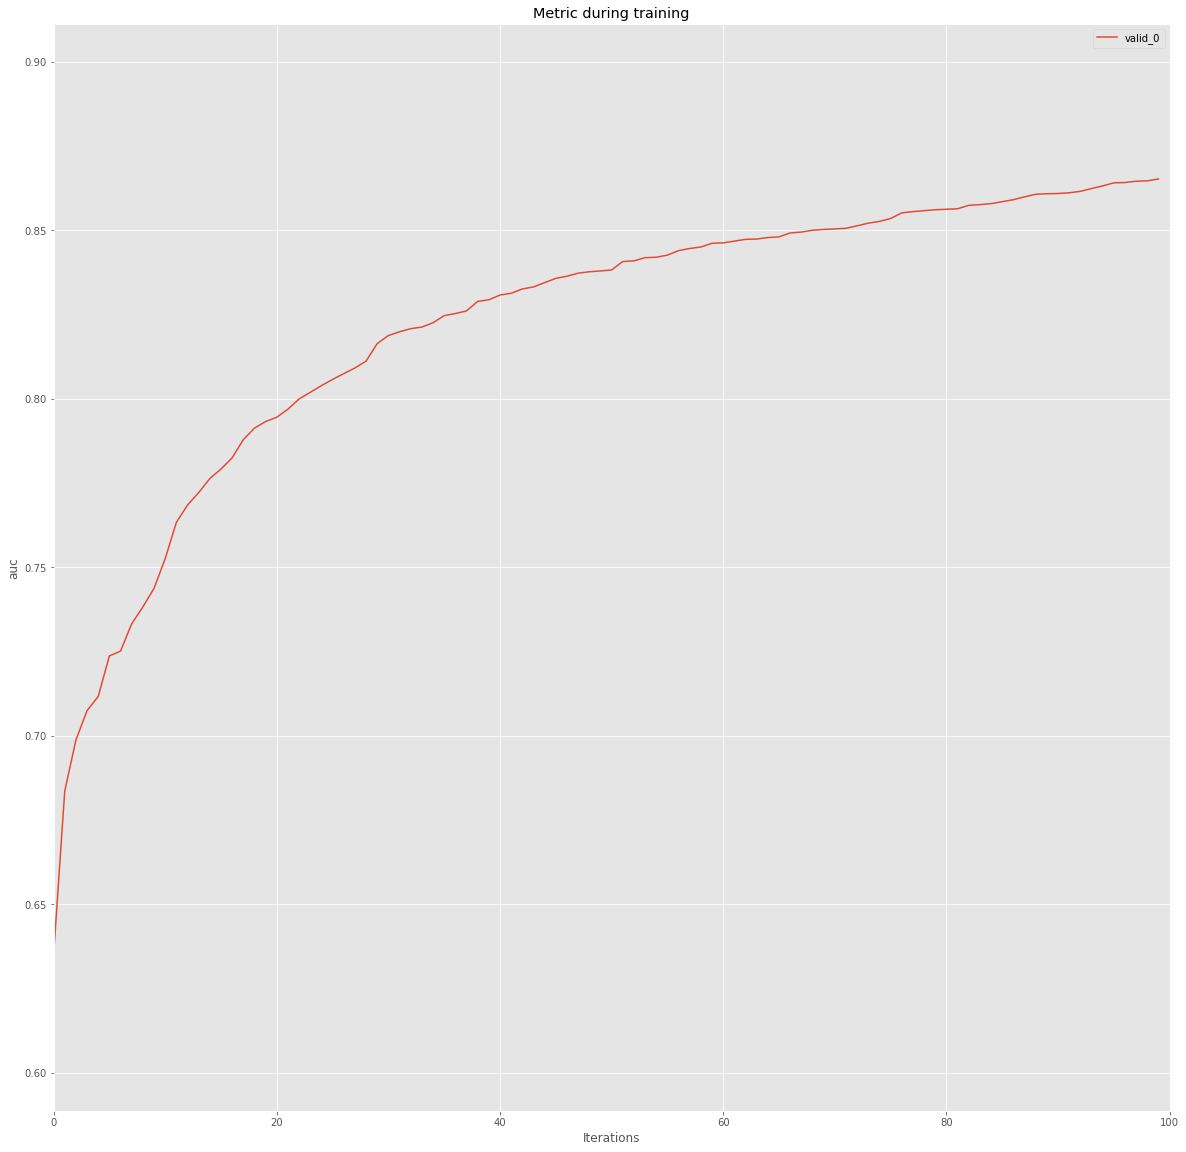

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.862607


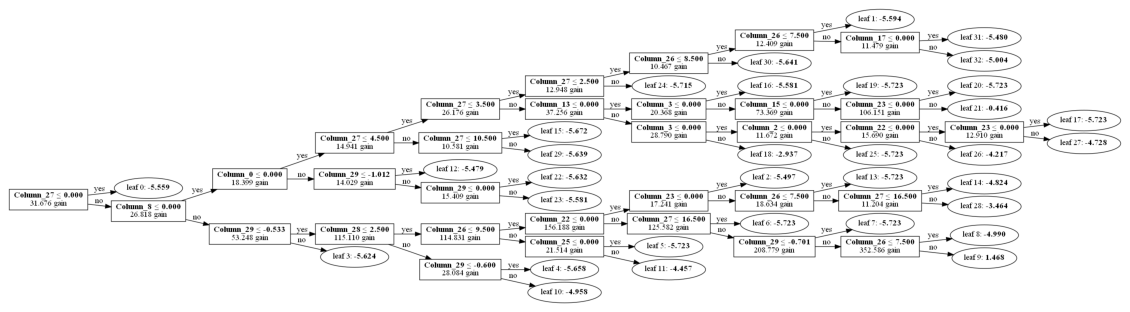

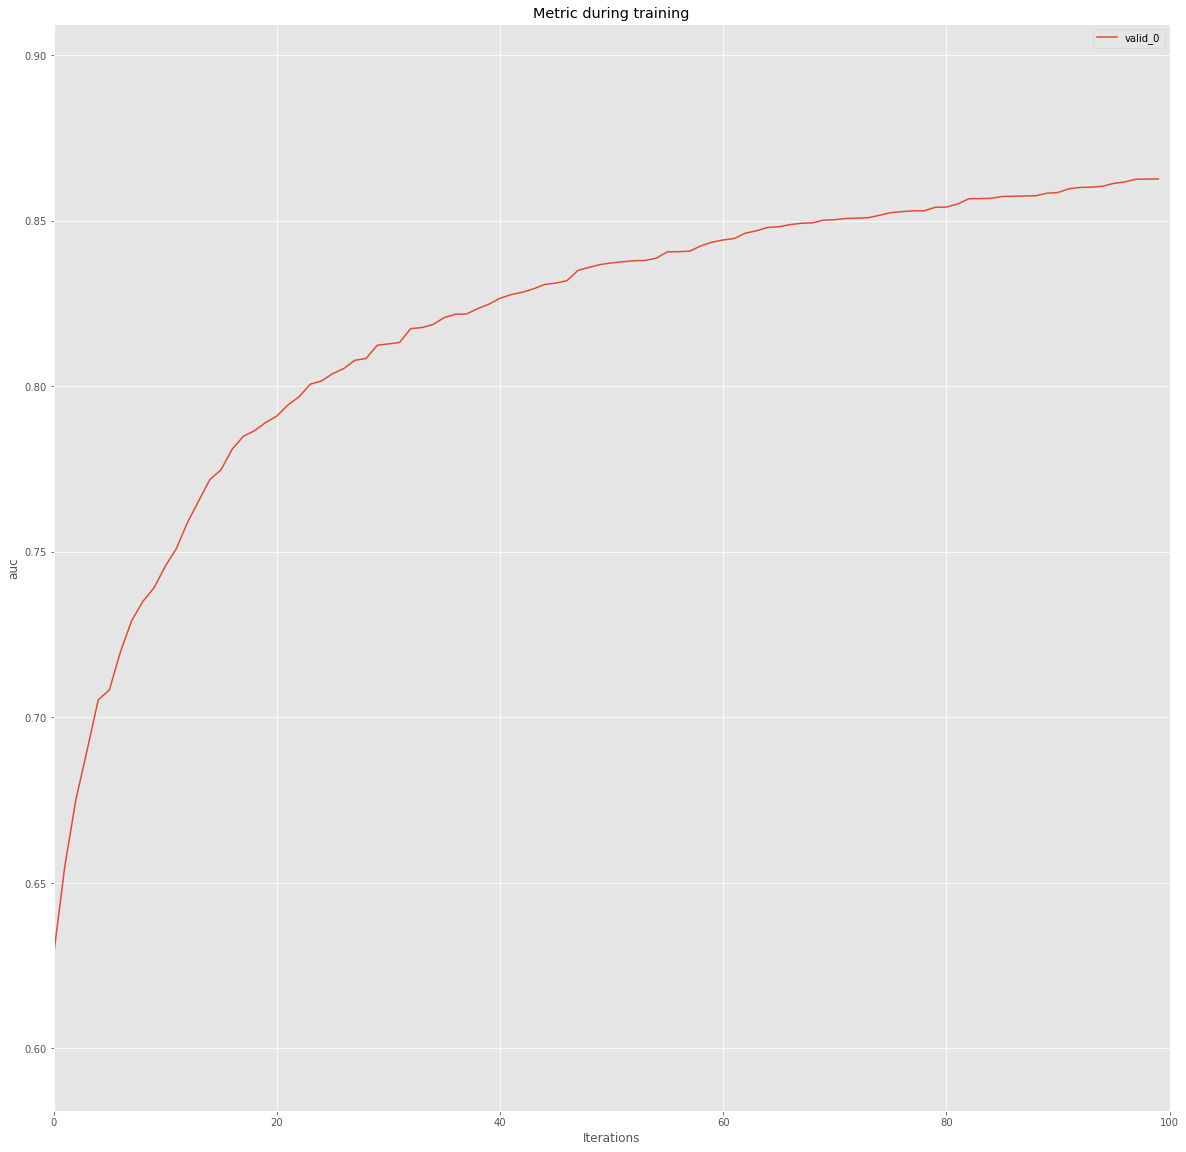

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.868255


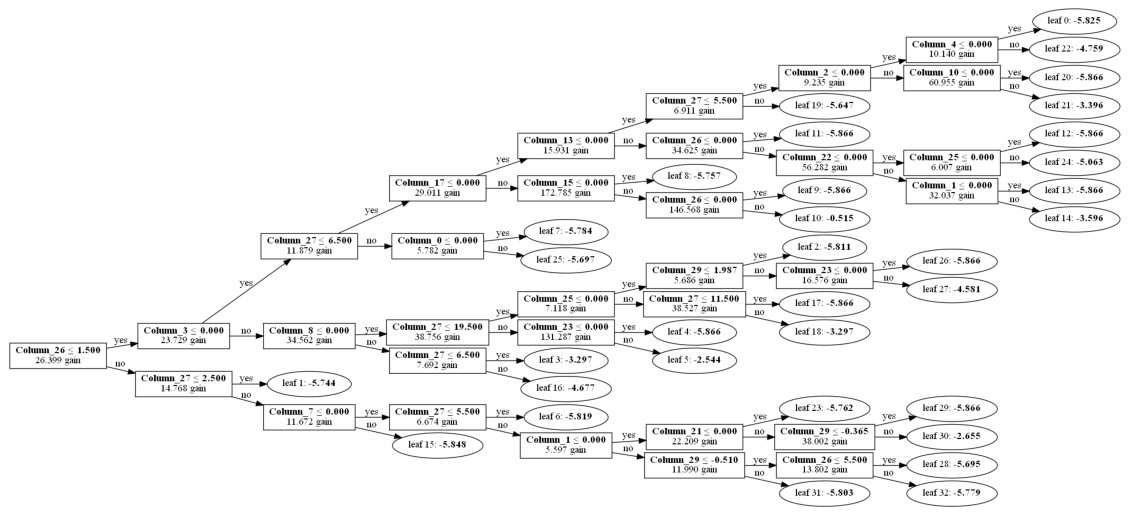

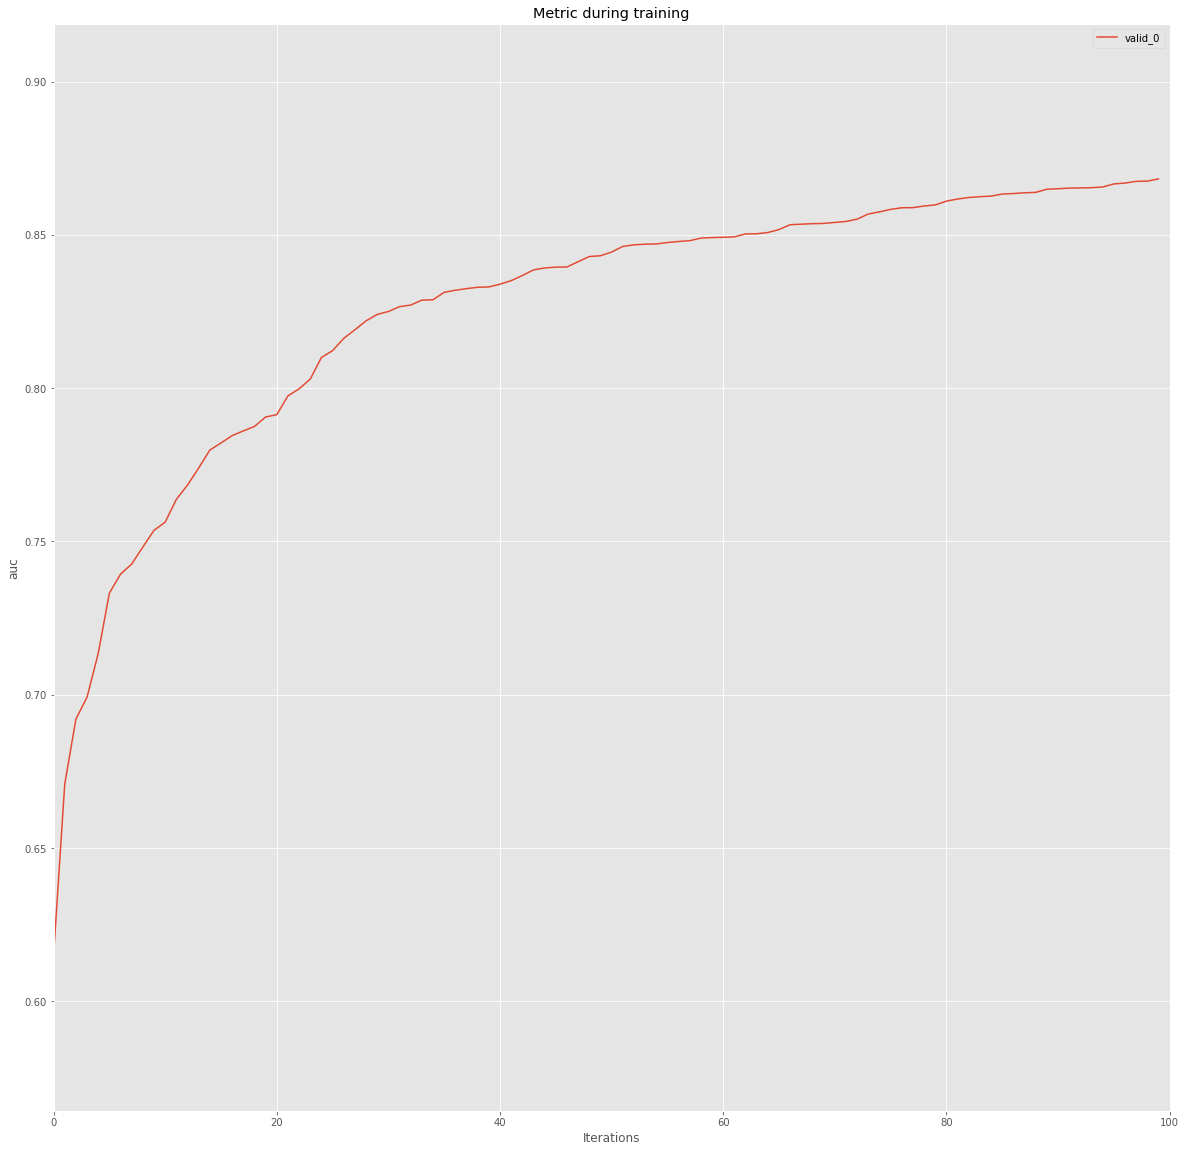

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.858922


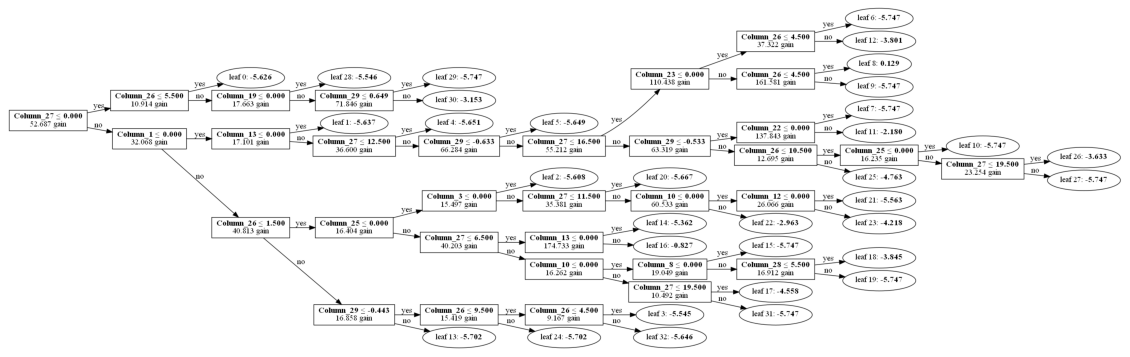

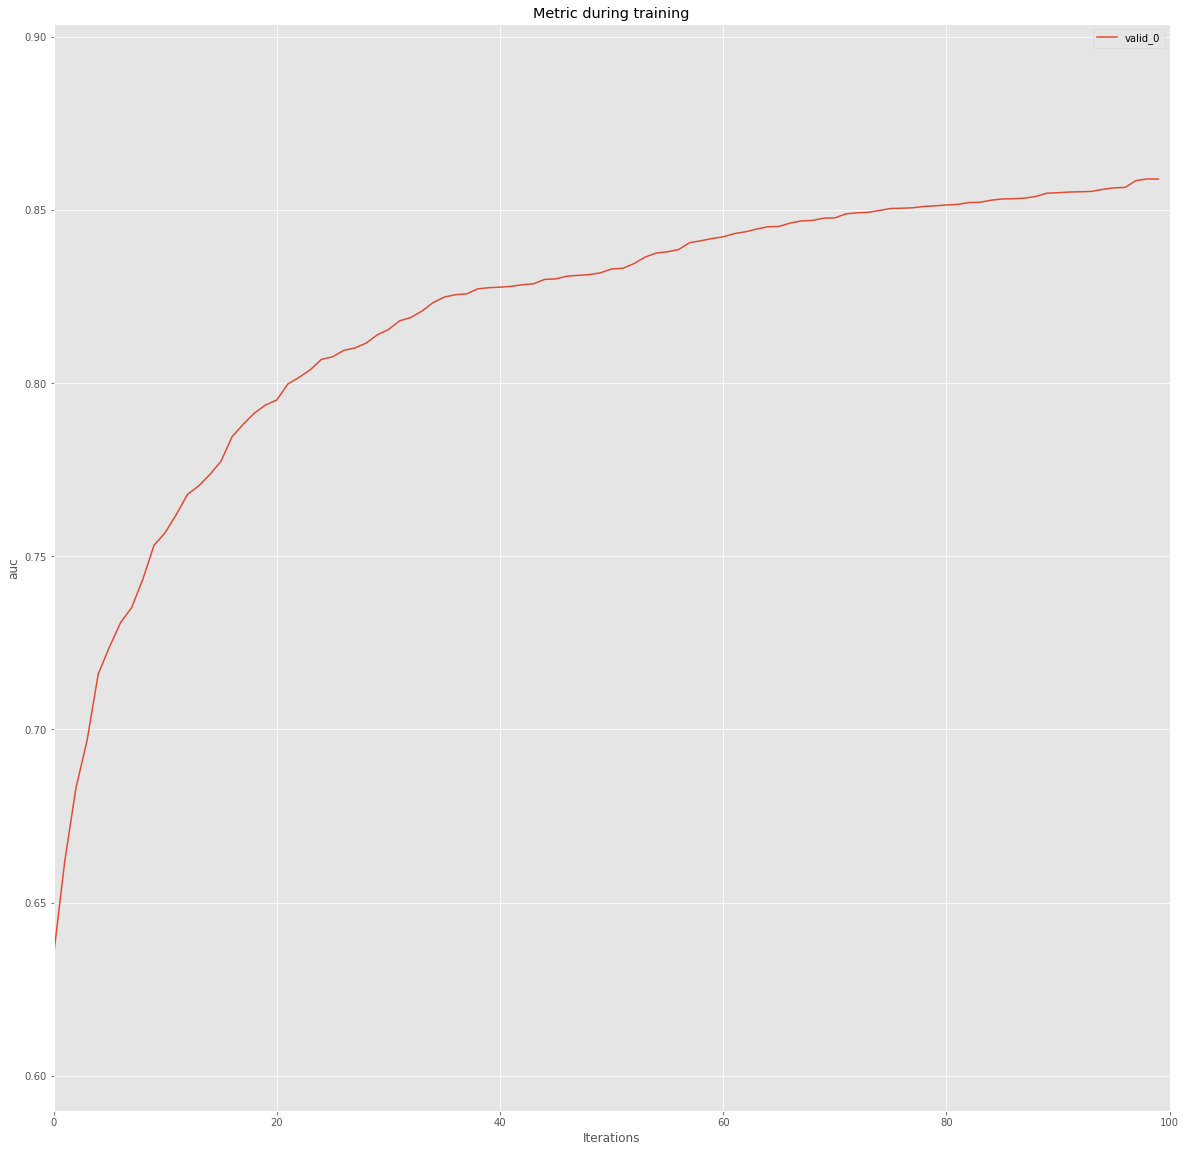

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.866055


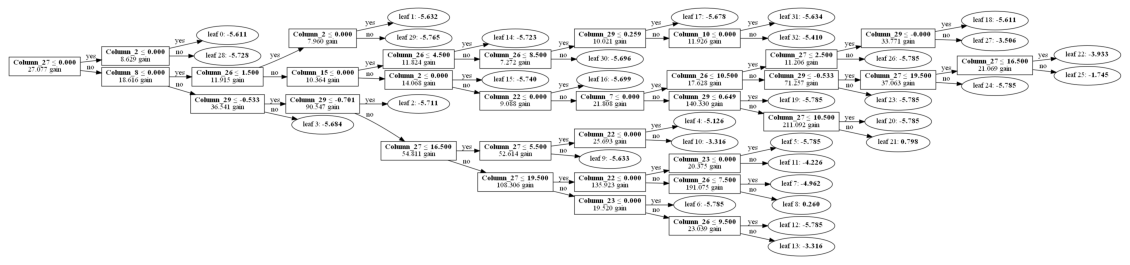

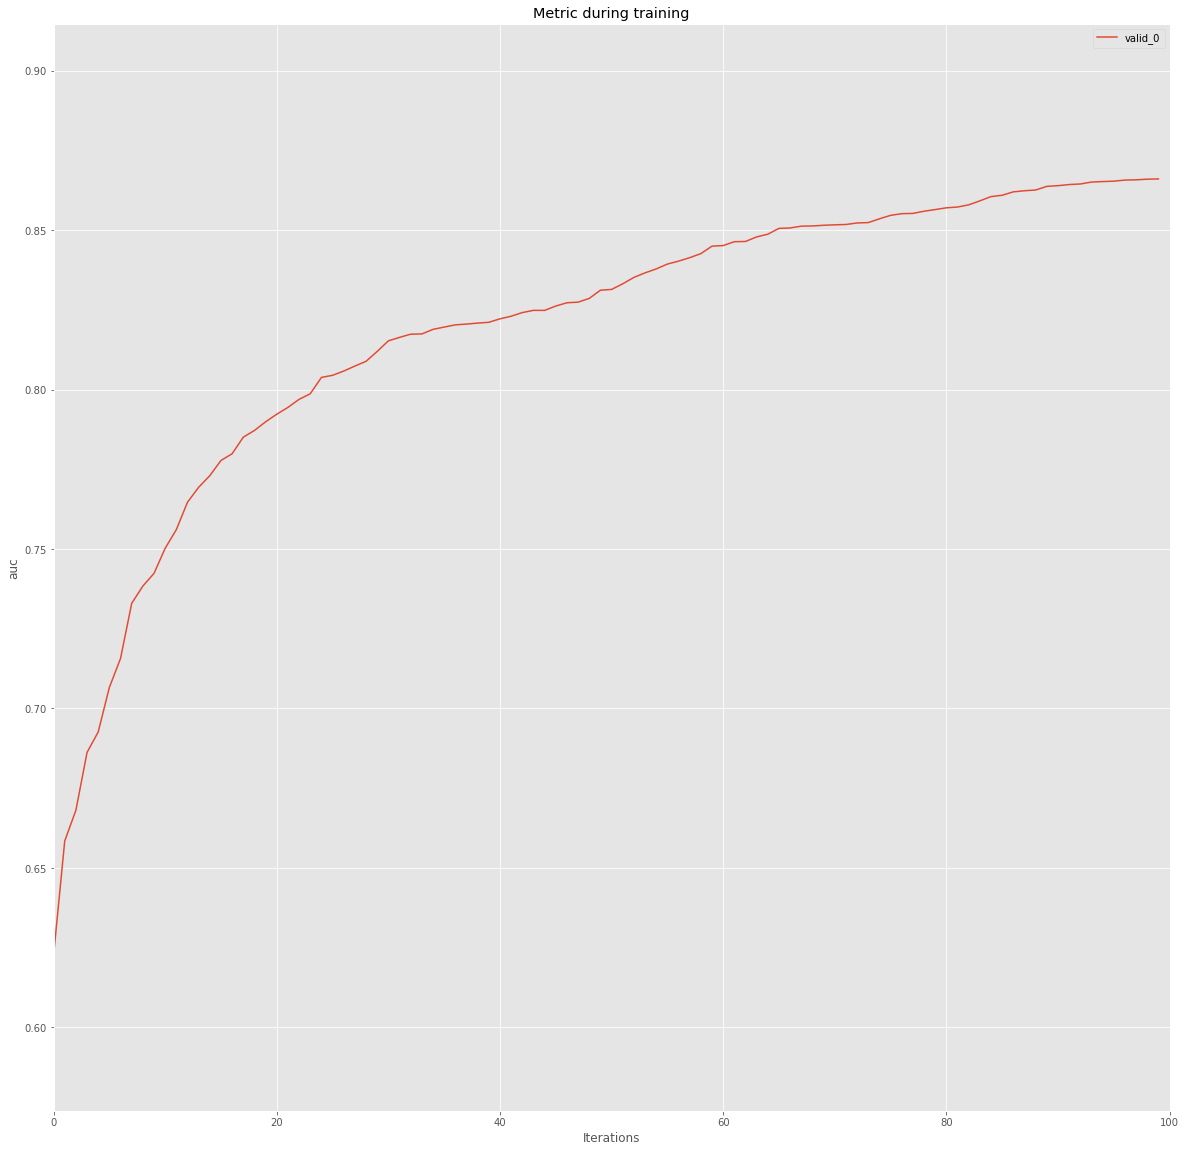

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.873458


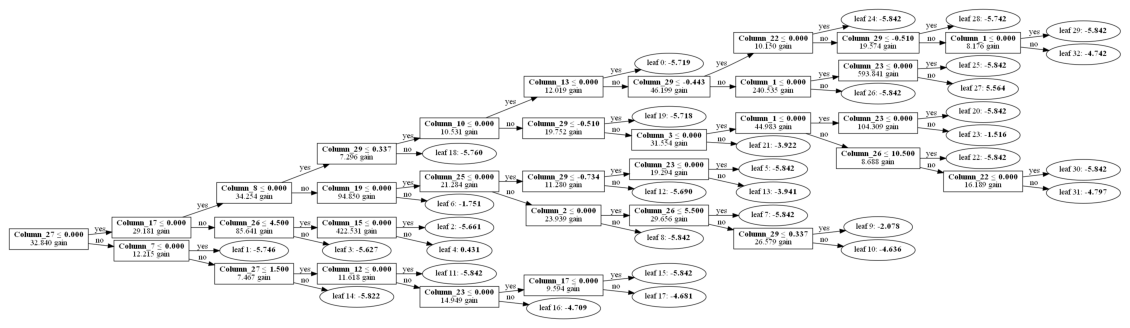

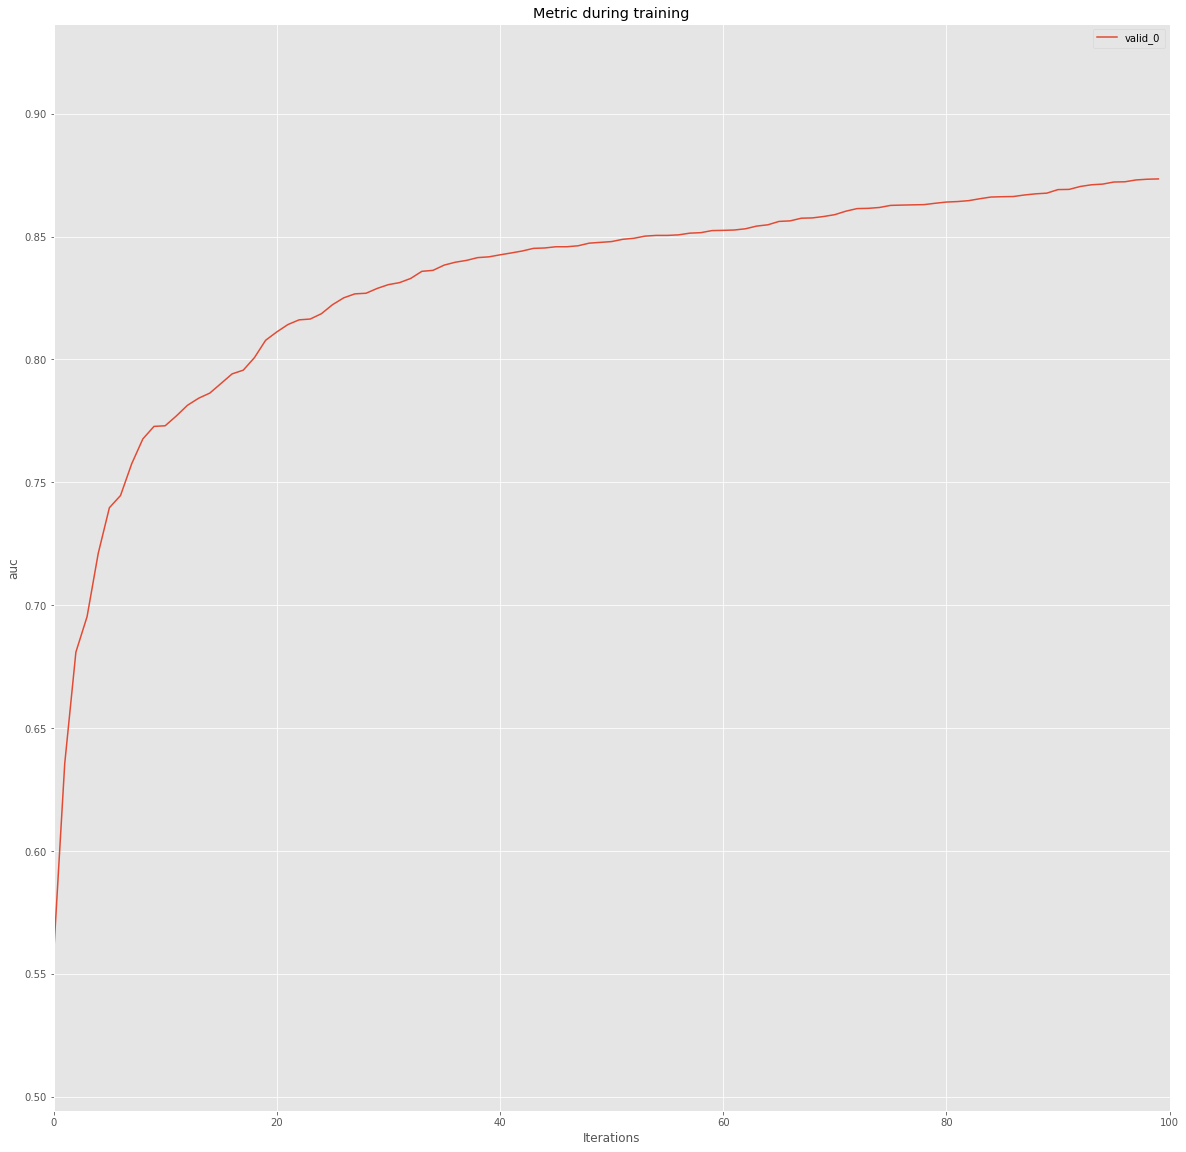

In [140]:
#データを訓練しreward=1となる確率をestimated_rewards(_by_reg_model)として出力

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],        #説明変数
    action=bandit_feedback["action"],          #説明変数
    reward=bandit_feedback["reward"],          #目的変数
    position=bandit_feedback["position"],      #3つ別々に学習を行う(position同士の影響はないことが仮定されている)
    pscore=bandit_feedback["pscore"],          #重み付けに利用(今回は無関係)
    n_folds=3,                                 #データを3等分してそれぞれ学習を行う
    random_state=456,                          #random seed
)

実際に学習を行う<br>
3-fold cross fittingを3つのpositionに対して行うので決定木は9つ得られる
- Kfold cross-fittingには過学習の防止(によるbiasの減少)と全データが学習に使えるというメリットがある

# OffPolicyEvaluationの実施

## OffPolicyEvaluatioに使用する推定器を設定しクリック率を予測する

In [141]:
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,                #元データを渡す
    ope_estimators=[ReplayMethod(), DoublyRobust()] #ReplayMethodとDoublyRobustを使用
)

ReplayMethodとDoublyRobustをestimatorとして使用し比較する
- ReplayMethodはクリックされたか否かが分かっている箇所のみ取り出してクリック率を計算する。すなわち配布データと同じ選択をしているもののみ取り出してrewardを推測する
    - これは分かりやすい方法である一方、(今回は問題ないが、)ログデータのpolicyがrandomでないと偏りが出てしまい、推定量として不適切であり、新しい商品が登場するたびにオンラインでテストをしてログデータを集めなければいけないデメリットがある
        - Li,L., &Chu,W., &Langford,J., &Wang,X.(2010) Unbiased Offline Evaluation of Contextual-bandit-based News Article Recommendation Algorithms. 1-5 https://arxiv.org/abs/1003.5956
<br>
<br>
- DoublyRobustは配布されたログデータを使用し、特徴量から目的変数rewardの期待値を推定するモデルを機械学習から求める。これによりログデータにない推薦をした場合でもモデルに基づいてクリックされるか否かを予測するができるようになる。さらに機械学習モデルによる目的変数rewardの期待値の推定誤差を(新旧policyの行動選択確率の比で)重み付けすることによって補正することによってbias-varianceトレードオフを軽減させる手法



## 推定クリック率の図示

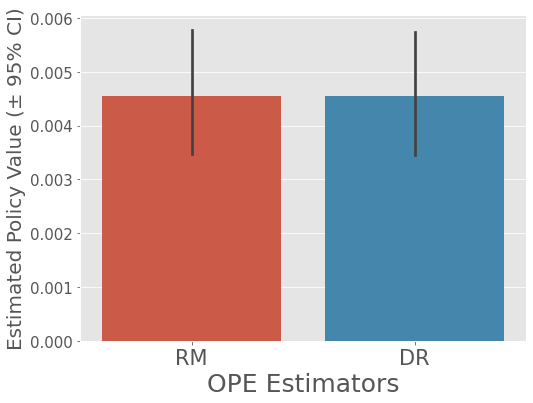

In [142]:
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000,  #bootstrapのサンプリング数
    random_state=3105,         #random_seed(bootstrapのサンプリングに使用)
    fig_dir = data_path,       #画像を保存するpath
)

棒グラフ部分は推定値、黒い棒は95%信頼区間を表している

## 推定クリック率の表示

In [143]:
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist, 
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000,  #bootstrapのサンプリング数
    random_state=3105,          #random_seed(bootstrapのサンプリングに使用)
)

In [144]:
estimated_policy_value #推定クリック率

,estimated_policy_value
rm,0.004541
dr,0.004547


In [145]:
estimated_policy_value.to_excel('estimated_policy_value.xlsx') #Excelファイル保存

In [146]:
estimated_policy_value_by_RM = estimated_policy_value.loc['rm', 'estimated_policy_value'] #ReplayMethodで推定したクリック率
estimated_policy_value_by_DR = estimated_policy_value.loc['dr', 'estimated_policy_value']#DoublyRobustで推定したクリック率

In [148]:
estimated_interval #クリック率の95%信頼区間(bootstrap法による推定) 

,mean,95.0% CI (lower),95.0% CI (upper)
rm,0.004532,0.003386,0.005772
dr,0.004537,0.003430,0.005720


In [149]:
estimated_interval.to_excel('estimated_interval.xlsx') #Excelファイル保存

# policyの性能比較

### random policyのpolicy value(クリック率)を導出する 

In [157]:
policy_value_random = bandit_feedback['reward'].mean()

In [158]:
policy_value_random

0.0033931764537586725

### contextual linear thompson samplingとrandsamplingとクリック率を比較する

In [151]:
print('ReplayMethodでは新ポリシ-はrandom policyと比べて'+str(100 * estimated_policy_value_by_RM / policy_value_random - 100)+'%優れていると推計できる')

ReplayMethodでは新ポリシ-はrandom policyと比べて33.82465379918534%優れていると推計できる


In [152]:
print('DoublyRobustでは新ポリシ-はrandom policyと比べて'+str(100 * estimated_policy_value_by_DR / policy_value_random - 100)+'%優れていると推計できる')

DoublyRobustでは新ポリシ-はrandom policyと比べて34.00524486101267%優れていると推計できる


Citation: Saito,Y., &Aihara,S., &Matsutani,M., &Narita,Y.(2020) Large-scale Open Dataset, Pipeline, and Benchmark for Bandit Algorithms 
arXiv preprint arXiv:2008.07146